In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark regression example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
import os, shutil
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics
from collections import Counter
import time


In [3]:
path = '/home/feng/Desktop'

In [4]:
def mkdir(path):
    """
    Make a new directory. if it's exist, keep the old files
    :param path: the directory path
    :author: Wenqiang Feng
    :email:  von198@gmail.com
    """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [5]:
def mkdir_clean(path):
    """
    Make a new directory. if it's exist, remove the old files
    :param path: the directory path
    :author: Wenqiang Feng
    :email:  von198@gmail.com
    """
    try:
        os.mkdir(path)
    except OSError:
        try:
            if len(os.listdir(path))!=0:
                shutil.rmtree(path)
                os.mkdir(path)
        except Exception as e:
            print(e)

In [6]:
def df_merge(dfs, key, how='left'):
    return reduce(lambda left,right: pd.merge(left,right,on=[key],
                                            how=how), dfs)

In [8]:
def dtypes_class(df_in):
    # __all__ = [
    # "DataType", "NullType", "StringType", "BinaryType", "BooleanType", "DateType",
    # "TimestampType", "DecimalType", "DoubleType", "FloatType", "ByteType", "IntegerType",
    # "LongType", "ShortType", "ArrayType", "MapType", "StructField", "StructType"]

    # numerical data types in rdd DataFrame dtypes
    num_types = ['DecimalType', 'DoubleType', 'FloatType', 'ByteType', 'IntegerType', 'LongType', 'ShortType']
    # qualitative data types in rdd DataFrame dtypes
    cat_types = ['NullType', 'StringType', 'BinaryType', 'BooleanType']
    # date data types in rdd DataFrame dtypes
    date_types = ['DateType', 'TimestampType']
    # unsupported data types in rdd DataFrame dtypes
    unsupported_types = ['ArrayType', 'MapType', 'StructField', 'StructType']

    all_fields = [(f.name, str(f.dataType)) for f in df_in.schema.fields]

    all_df = pd.DataFrame(all_fields, columns=['feature', 'DataType'])

    # initialize the memory for the corresponding fields
    num_fields = []
    cat_fields = []
    date_fields = []
    unsupported_fields = []

    [num_fields.append(item[0]) if item[1] in num_types else
     cat_fields.append(item[0]) if item[1] in cat_types else
     date_fields.append(item[0]) if item[1] in date_types else
     unsupported_fields.append(item[0]) for item in all_fields]

    return all_df, num_fields, cat_fields, date_fields, unsupported_fields


In [3]:
data = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load("Heart.csv",header=True);
data.count()

303

In [48]:
def data_types(df_in):

    #print('==========================================================')
    #print("Collecting data types.... Please be patient!") 
    start = time.time()    
    d_types = pd.DataFrame(df_in.dtypes, columns=['feature','dtypes'])

    end = time.time()
    #print('Generate counts took = ' +str(end-start)+' s') 
    
    return d_types

In [5]:
# data = spark.read.format('com.databricks.spark.csv').\
#                        options(header='true', \
#                        inferschema='true').\
#             load("/home/feng/Downloads/pmsm_temperature_data.csv",header=True);
# data.count()

In [129]:
data = spark.read.csv(path='renfe.csv',
                        sep=',',encoding='UTF-8',comment=None,header=True,inferSchema=True)
data.count()

2579771

In [11]:
df = spark.createDataFrame([(1.0, 19, "A", 1483695000, 21, None, None),
                            (2.0, 19, "A", 1483696500, 21, "France", None),
                            (3.0, 0, "A", 1483697800, 0, "France", "Engineer"),
                            (4.0, 19, '    ', 1483699000, 21, None, None),
                            (0.0, 0, "B", 1483699500, 0, "France", None),
                            (6.0, 19, "B", 1483699800, 21, "France", "Engineer"),
                            (7.0, 24, "C", 1483699200, None, None, None),
                            (8.0, 24, '  ', 1483699560, 28, "Spain", None),
                            (9.0, 0, "D", 1483699840, 28, "Spain", "Student")],
                            ["id","ClientNum","Value","Date","Age", "Country", "Job"])

In [125]:
data = spark.createDataFrame([(1.0, 19, "A", 1483695000, 21, None, None, '2019-06-29'),
                            (2.0, 19, "A", 1483696500, 21, "France", None, '2019-06-29'),
                            (3.0, 0, "A", 1483697800, 0, "France", "Engineer", '2019-06-29'),
                            (4.0, 19, '    ', 1483699000, 21, None, None, '2019-06-29'),
                            (0.0, 0, "B", 1483699500, 0, "France", None, '2019-06-29'),
                            (6.0, 19, "B", 1483699800, 21, "France", "Engineer", '2019-06-29'),
                            (7.0, 24, "C", 1483699200, None, None, None, '2019-06-29'),
                            (8.0, 24, '  ', 1483699560, 28, "Spain", None, '2019-06-29'),
                            (9.0, 0, "D", 1483699840, 28, "Spain", "Student", '2019-06-29')],
                            ["id","ClientNum","Value","Date","Age", "Country", "Job",'Load_date'])

In [14]:
def counts(df_in):
    
    print('==========================================================')
    print("Collecting features' counts.... Please be patient!")    
    start = time.time()
    row_count = df_in.count()
    
    f_counts = pd.DataFrame([(c, row_count, df_in.na.drop(subset=[c]).select(c).count(),
                         df_in.na.drop(subset=[c]).select(c).distinct().count()) for c in df_in.columns],
                        columns=['feature','row_count','notnull_count','distinct_count'])
    end = time.time()
    print('Generate counts took = ' +str(end-start)+' s') 
    
    return f_counts 
 

In [15]:
def describe(df_in, columns=None):

    print('==========================================================')
    print("Collecting data frame description.... Please be patient!")      
    start = time.time()
    if columns:
        df_in = df_in.select(columns)
    desc = df_in.describe().toPandas().set_index('summary').transpose().rename_axis('feature')    
    end = time.time()
    print('Generate data frame description took = ' +str(end-start)+' s')     
    
    return desc

In [16]:
def feature_len(df_in):

    print('==========================================================')
    print("Calculating features' length.... Please be patient!")
    start = time.time()
    cols = df_in.columns
    features_len = df_in.select(*(F.length(F.col(c)).alias(c) for c in cols))
    summary_len = features_len.agg(*(F.min(F.col(c)).alias(c) for c in cols)) \
        .union(features_len.agg(*(F.avg(F.col(c)).alias(c) for c in cols))) \
        .union(features_len.agg(*(F.max(F.col(c)).alias(c) for c in cols))) \
        .toPandas().transpose().reset_index()
    summary_len.columns = ['feature','min_length', 'avg_length', 'max_length']
    end = time.time()

    print("Generate features' length took = " + str(end - start) + ' s')
    
    return summary_len

In [17]:
def percentiles(df_in, deciles=False):
    
    print('==========================================================')
    print('Calculating percentiles.... Please be patient!')
    start = time.time()
    cols = df_in.columns
    if deciles:
        percentiles = list(np.array(range(0, 110, 10))/100)
        names = [str(int(p*100)) + '%' for p in percentiles]
    else:
        percentiles = [0.25, 0.50, 0.75]
        names = ['Q1', 'Med', 'Q3']
        
    percens = [df_in.approxQuantile(c, percentiles, 0.00) for c in cols]
    percentiles = pd.DataFrame(percens, columns=names, index=cols).rename_axis('feature').reset_index()

    end = time.time()
    print('Generate percentiles took = ' + str(end - start) + ' s')
    
    return percentiles

In [18]:
def freq_items(df_in, top_n=5):
    """

    :param df_in:
    :param top_n:
    :return:
    """

    
    print('==========================================================')
    print('Calculating top {} frequent items.... Please be patient!'.format(top_n))
    start = time.time()
    freq = [[[item[0], item[1]] for item in df_in.groupBy(col).count().sort(F.desc('count')).take(top_n)]
            for col in df_in.columns]
    
    end = time.time()
    print('Generate rates took: ' + str(end-start) + ' s') 
    
    return pd.DataFrame({'feature': df_in.columns, 'freq_items[value, freq]': freq})

In [41]:
def rates(df_in, columns=None, numeric=True):
    
    print('==========================================================')
    print('Calculating rates.... Please be patient!')    
    if columns is None:
        _, num_fields, cat_fields,_ ,_ = dtypes_class(df_in)
        columns = num_fields + cat_fields  
        
    start = time.time()
    rate_null = []
    rate_empty = []
    rate_pos = []
    rate_neg = []
    rate_zero = []
    rate_variance = []

    data = df_in.select(columns)
    total = data.count()    
    
    if numeric:
        [(rate_null.append(data.filter(F.col(c).isNull()).count() / total),
          rate_empty.append(data.filter(F.trim(F.col(c)) == '').count() / total),
          rate_pos.append(data.filter(F.col(c) > 0).count() / total),
          rate_neg.append(data.filter(F.col(c) < 0).count() / total),
          rate_zero.append(data.filter(F.col(c) == 0).count() / total),
          rate_variance.append(data.na.drop(subset=[c]).select(c).distinct().count()/
                              data.na.drop(subset=[c]).select(c).count())) for c in data.columns]

        d = {'feature': columns, 'feature_variance':rate_variance, 'rate_null': rate_null, 
                             'rate_empty': rate_empty,'rate_neg': rate_neg, 'rate_zero': rate_zero, 
                             'rate_pos': rate_pos}
    else:
        [(rate_null.append(data.filter(F.col(c).isNull()).count() / total),
          rate_empty.append(data.filter(F.trim(F.col(c)) == '').count() / total),
          rate_variance.append(data.na.drop(subset=[c]).select(c).distinct().count()/
                              data.na.drop(subset=[c]).select(c).count())) for c in data.columns]


        d = {'feature': columns, 'feature_variance':rate_variance, 'rate_null': rate_null, 
                             'rate_empty': rate_empty}
        
    end = time.time()
    print('Generate rates took: ' + str(end-start) + ' s') 
    
    return pd.DataFrame(d)

In [45]:
_, num_fields, cat_fields,_ ,_ = dtypes_class(data)
rates(data, columns=cat_fields, numeric=False)

Calculating rates.... Please be patient!
Generate rates took: 25.188928365707397 s


,feature,feature_variance,rate_null,rate_empty
0,origin,0.000002,0.000000,0.0
1,destination,0.000002,0.000000,0.0
2,train_type,0.000006,0.000000,0.0
3,train_class,0.000002,0.003746,0.0
4,fare,0.000003,0.003746,0.0


In [104]:
def corr_matrix(df_in, method="pearson", output_dir=None, rotation=False, display=False):
    
    _, num_fields,_,_ ,_ = dtypes_class(df_in)
    
    if len(num_fields)>1:
        df_in = df_in.select(num_fields)
        
        if output_dir is None:
            out_path = os.getcwd()+'/Audited'
        else:
            out_path = output_dir+'/Audited'
        mkdir(out_path)

        print('==========================================================')
        print('The correlation matrix plot Corr.png was located at:')
        print(out_path)
        print('Calculating correlation matrix... Please be patient!')  

        start = time.time()
        # convert the rdd data data frame to dense matrix
        col_names = df_in.columns
        features = df_in.rdd.map(lambda row: row[0:])

        # calculate the correlation matrix
        corr_mat = Statistics.corr(features, method=method)
        corr = pd.DataFrame(corr_mat)
        corr.index, corr.columns = col_names, col_names

        # corr.to_csv('{}/corr_mat.csv'.format(out_path))

        fig = plt.figure(figsize=(20,15))  # Push new figure on stack
        sns_plot = sns.heatmap(corr, cmap="YlGnBu",
                               xticklabels=corr.columns.values, 
                               yticklabels=corr.columns.values)
        if rotation:
            plt.xticks(rotation=90,fontsize=20)
            sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation=0,fontsize=20)
        plt.savefig("{}/02-correlation_mat.png".format(out_path))
        if display:
            plt.show()
        plt.clf()
        plt.close(fig)
        end = time.time()
        print('Generate correlation matrix took = ' +str(end-start)+' s')

        return corr

In [105]:
# done
def hist_plot(df_in, bins=50, output_dir=None, sample_size=None, display=False):

    _, num_fields,_,_ ,_ = dtypes_class(df_in)
    
    if num_fields:
        df_in = df_in.select(num_fields)

        if output_dir is None:
            out_path = os.getcwd()+'/Audited'
        else:
            out_path = output_dir+'/Audited'
        mkdir(out_path)

        start = time.time()
        if (df_in.count() <=10000) or (sample_size is not None and sample_size<=10000):
            print('==========================================================')
            print('The Histograms plot Histograms.pdf was located at:')
            print(out_path)
            pdf = PdfPages(out_path+'/03-Histograms.pdf')
            for col in df_in.columns:
                if sample_size is None:
                    data = df_in.select(col).na.drop().toPandas()
                else: 
                    data = df_in.select(col).na.drop().toPandas().sample(n=sample_size, random_state=1)

                print('Plotting histograms of {}.... Please be patient!'.format(col))
                # Turn interactive plotting off
                plt.ioff()
                fig = plt.figure(figsize=(20,15))
                sns.distplot(data,bins=bins,kde=False, rug=True)
                plt.title('Histograms of {}'.format(col),fontsize=20)
                plt.xlabel('{}'.format(col), fontsize=20)
                plt.ylabel('number of counts', fontsize=20)
                pdf.savefig(fig)
                if display:
                    plt.show()
                plt.close(fig)
            print('Histograms plots are done!')    
            pdf.close()    
        else:  
            mkdir_clean(out_path+'/03-hist')
            print('==========================================================')
            print('The Histograms plots *.png were located at:')
            print(out_path+'/03-hist')
            for col in df_in.columns:
                if sample_size is None:
                    data = df_in.select(col).na.drop().toPandas()
                else: 
                    data = df_in.select(col).na.drop().toPandas().sample(n=sample_size, random_state=1)

                print('Plotting histograms of {}.... Please be patient!'.format(col))
                fig = plt.figure(figsize=(20,15))
                sns.distplot(data,bins=bins,kde=False, rug=True)
                plt.title('Histograms of {}'.format(col), fontsize=20)
                plt.xlabel('{}'.format(col), fontsize=20)
                plt.ylabel('number of counts', fontsize=20)
                plt.savefig(out_path+'/03-hist/'+"{}.png".format(col))
                if display:
                    plt.show()
                plt.clf()
                plt.close(fig)
            print('Histograms plots are done!')
        end = time.time()
        print('Generate histograms plots took = ' +str(end-start)+' s')
    else:
        print('Caution: no numerical features in the dataset!!!')


In [106]:
def bar_plot(df_in, top_n=20, rotation=True, output_dir=None, display=False):
    
    _,_,cat_fields,date_fields ,_ = dtypes_class(df_in)
    
    cat_fields = cat_fields + date_fields
    if cat_fields:
        df_in = df_in.select(cat_fields)

        if output_dir is None:
            out_path = os.getcwd()+'/Audited'
        else:
            out_path = output_dir+'/Audited'
        mkdir(out_path)
        
        print('==========================================================')
        print('The Bar plot Bar_plots.pdf was located at:')
        print(out_path)
        start = time.time()
        pdf = PdfPages(out_path+'/04-Bar_plots.pdf')
        for col in df_in.columns:
            p_data = df_in.select(col).na.drop().groupBy(col).count().sort(F.desc('count')).limit(top_n).toPandas()

            print('Plotting barplot of {}.... Please be patient!'.format(col))
            plt.ioff()
            fig = plt.figure(figsize=(20,15))
            sns.barplot(x=col, y="count", data=p_data)
            plt.title('Barplot of {}'.format(col),fontsize=20)
            plt.xlabel('{}'.format(col), fontsize=20)
            plt.ylabel('number of counts', fontsize=20)
            if rotation:
                plt.xticks(rotation=90)
            pdf.savefig(fig)
            if display:
                plt.show()
            plt.close(fig)
        print('Bar plots are done!')    
        pdf.close() 

        end = time.time()
        print('Generate bar plots took = ' +str(end-start)+' s')    
    else:
        print('Caution: no categorical features in the dataset!!!')    

In [107]:
def trend_plot(df_in, types='month', d_time=None, rotation=True, output_dir=None, display=False):

    _, num_fields, _, date_fields ,_ = dtypes_class(df_in)


    if date_fields:

        if d_time is None:
            d_time = date_fields[0]        
        
        if output_dir is None:
            out_path = os.getcwd()+'/Audited'
        else:
            out_path = output_dir+'/Audited'
        mkdir(out_path)        

        print('==========================================================')
        print('The Trend plot Trend_plots.pdf was located at:')
        print(out_path)        

        start = time.time()        
        pdf = PdfPages(out_path+'/05-Trend_plots.pdf')
        if types == 'day':
            ts_format = 'yyyy-MM-dd'
        elif types == 'month':
            ts_format = 'yyyy-MM'
        elif types == 'year':
            ts_format = 'yyyy'

        for col in num_fields:

            p_data = df_in.select(F.date_format(d_time,ts_format).alias(types), col)\
                        .groupBy(types).agg(F.mean(col).alias("mean"),F.sum(col).alias("sum")).toPandas()

            print('Plotting trend plot of {}.... Please be patient!'.format(col))
            plt.ioff()
            sns.set(style="ticks", rc={"lines.linewidth": 2})
            fig, axes = plt.subplots(1, 2, figsize=(20,10))
            sns.lineplot(x= types, y="mean",data=p_data, ax=axes[0])
            axes[0].set_title('Mean trend of {} in {}'.format(col,types))
            sns.lineplot(x= types, y="sum", data=p_data, ax=axes[1])
            axes[1].set_title('Sum trend of {} in {}'.format(col,types))

            if rotation:
                for ax in fig.axes:
                    plt.sca(ax)
                    plt.xticks(rotation=90, fontsize=8) 

            pdf.savefig(fig)  

            if display:
                plt.show()    
            plt.close(fig)
        print('Trend plots are done!') 
        pdf.close()

        end = time.time()
        print('Generate trend plots took = ' +str(end-start)+' s')            
    else:
        print('Caution: no date features in the dataset!!!')          

In [108]:
def numeric_summary(df_in, columns=None, deciles=False, top_n=5):
    
    _, num_fields, _,_ ,_ = dtypes_class(df_in)
    
    if num_fields:
        start = time.time()  
        num = df_in.select(num_fields)
        if columns:
            num = num.select(columns)
            
        d_types = data_types(num)
        f_counts = counts(num)
        des = describe(num, columns=columns)
        percs =  percentiles(num, deciles=deciles)
        f_len = feature_len(num)
        freq = freq_items(num, top_n=top_n) 
        rate = rates(num, columns=columns, numeric=True)

        data_frames =[d_types, f_counts, des, percs, f_len, freq, rate]
        num_summary = df_merge(data_frames, 'feature').drop(['count'],axis=1)

        end = time.time()
        print('Auditing numerical data took = ' +str(end-start)+' s')
        return num_summary
    else:
        print('Caution: no numerical features in the dataset!!!')        

In [49]:
numeric_summary(data)

Generate counts took = 0.001190185546875 s
Generate counts took = 5.540020227432251 s
Generate data frame description took = 1.0816826820373535 s
Calculating percentiles.... Please be patient!
Generate percentiles took = 16.56355094909668 s
Calculating features' length.... Please be patient!
Generate features' length took = 4.037298202514648 s
Calculating top 5 frequent items.... Please be patient!
Generate rates took: 3.4505956172943115 s
Calculating rates.... Please be patient!
Generate rates took: 17.28028702735901 s
Auditing numerical data took = 47.978354930877686 s


,feature,dtypes,row_count,notnull_count,distinct_count,mean,stddev,min,max,Q1,...,min_length,avg_length,max_length,"freq_items[value, freq]",feature_variance,rate_null,rate_empty,rate_neg,rate_zero,rate_pos
0,_c0,int,2579771,2579771,2579771,1289885.0,744715.8849863483,0,2579770,644943.00,...,1.0,6.569299,7.0,"[[53, 1], [255, 1], [481, 1], [588, 1], [799, 1]]",1.000000,0.00000,0.0,0.0,3.876313e-07,1.00000
1,price,double,2579771,2269090,225,63.3855034177177,25.78318663353166,15.45,214.2,43.75,...,4.0,4.519243,6.0,"[[None, 310681], [76.3, 166085], [28.35, 14182...",0.000099,0.12043,0.0,0.0,0.000000e+00,0.87957


In [87]:
def category_summary(df_in, columns=None, top_n=5):
    
    _, _, cat_fields,_ ,_ = dtypes_class(df_in)
    
    if cat_fields:
        start = time.time()  
        cat = df_in.select(cat_fields)
        if columns:
            cat = cat.select(columns)

        d_types = data_types(cat)
        f_counts = counts(cat)
        f_len = feature_len(cat)
        freq = freq_items(cat,  top_n=top_n) 
        rate = rates(cat, columns=columns, numeric=False)
        
        data_frames =[d_types, f_counts, f_len, freq, rate]
        cat_summary = df_merge(data_frames, 'feature')

        end = time.time()
        print('Auditing categorical data took = ' +str(end-start)+' s')        
        return cat_summary
    else:
        print('Caution: no numerical features in the dataset!!!')   

In [51]:
category_summary(data)

Generate counts took = 0.0012295246124267578 s
Generate counts took = 11.652791976928711 s
Calculating features' length.... Please be patient!
Generate features' length took = 4.104576587677002 s
Calculating top 5 frequent items.... Please be patient!
Generate rates took: 5.883784532546997 s
Calculating rates.... Please be patient!
Generate rates took: 64.89331984519958 s
Auditing categorical data took = 86.56404662132263 s


,feature,dtypes,row_count,notnull_count,distinct_count,min_length,avg_length,max_length,"freq_items[value, freq]",feature_variance,rate_null,rate_empty,rate_neg,rate_zero,rate_pos
0,origin,string,2579771,2579771,5,6.0,7.021123,10.0,"[[MADRID, 1359423], [BARCELONA, 405621], [SEVI...",0.000002,0.000000,0.0,0.0,0.0,0.0
1,destination,string,2579771,2579771,5,6.0,7.131416,10.0,"[[MADRID, 1220348], [BARCELONA, 480074], [SEVI...",0.000002,0.000000,0.0,0.0,0.0,0.0
2,train_type,string,2579771,2579771,16,2.0,4.076078,9.0,"[[AVE, 1789258], [ALVIA, 182267], [REGIONAL, 1...",0.000006,0.000000,0.0,0.0,0.0,0.0
3,train_class,string,2579771,2570107,6,7.0,8.402418,18.0,"[[Turista, 1950303], [Preferente, 256082], [Tu...",0.000002,0.003746,0.0,0.0,0.0,0.0
4,fare,string,2579771,2570107,7,4.0,6.088644,19.0,"[[Promo, 1733423], [Flexible, 582743], [Adulto...",0.000003,0.003746,0.0,0.0,0.0,0.0


The Trend plot Trend_plots.pdf was located at:
/home/feng/Dropbox/MyTutorial/PythonTipsDS/PythonTipsDS/doc/code/audit/Audited
Plotting trend plot of _c0.... Please be patient!


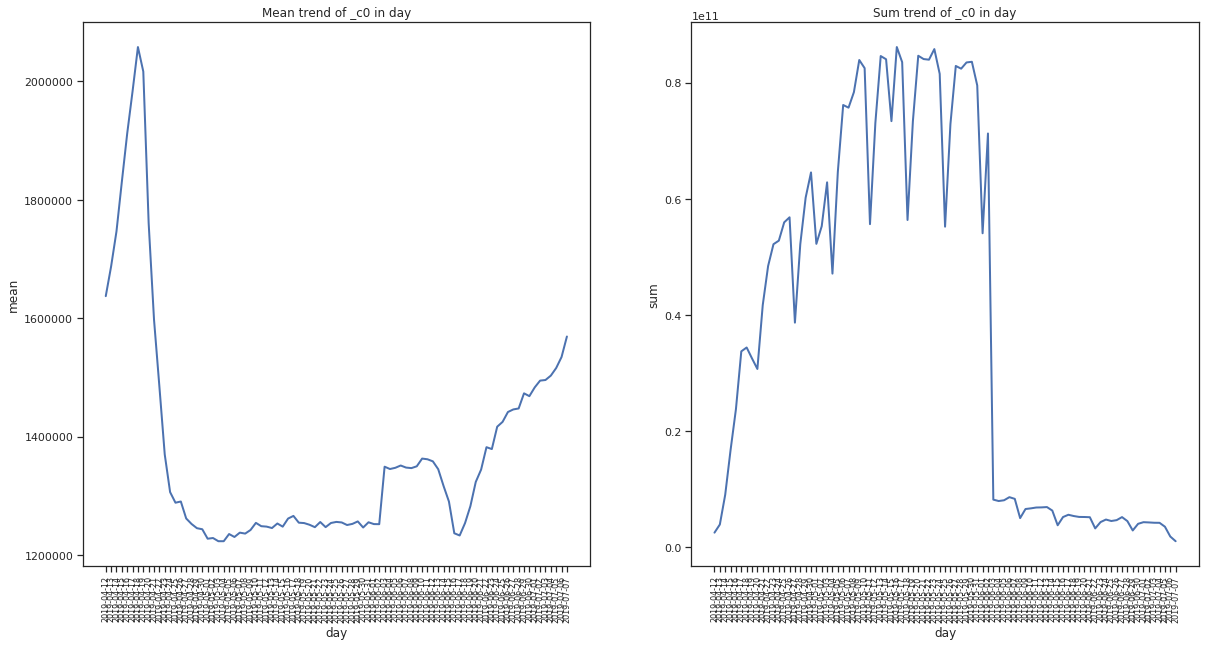

Plotting trend plot of price.... Please be patient!


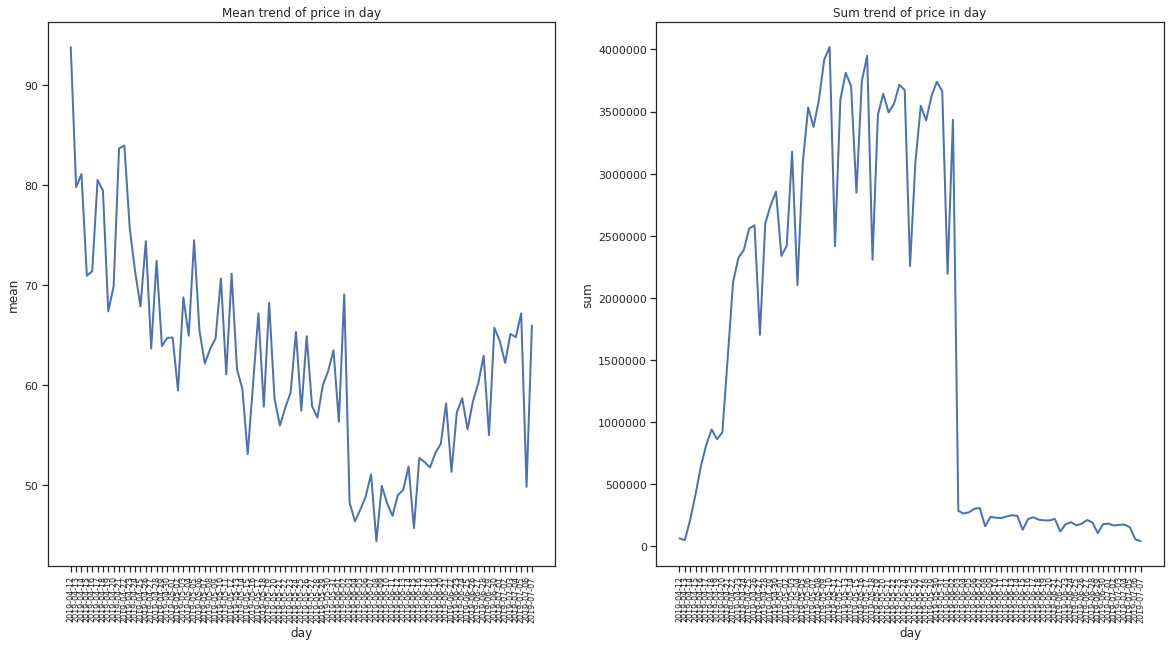

Trend plots are done!
Generate trend plots took = 17.88880944252014 s


In [36]:
trend_plot(data, d_time='start_date', types='day', display=True)

The Bar plot Bar_plots.pdf was located at:
/home/feng/Dropbox/MyTutorial/PythonTipsDS/PythonTipsDS/doc/code/audit/Audited
Plotting barplot of origin.... Please be patient!


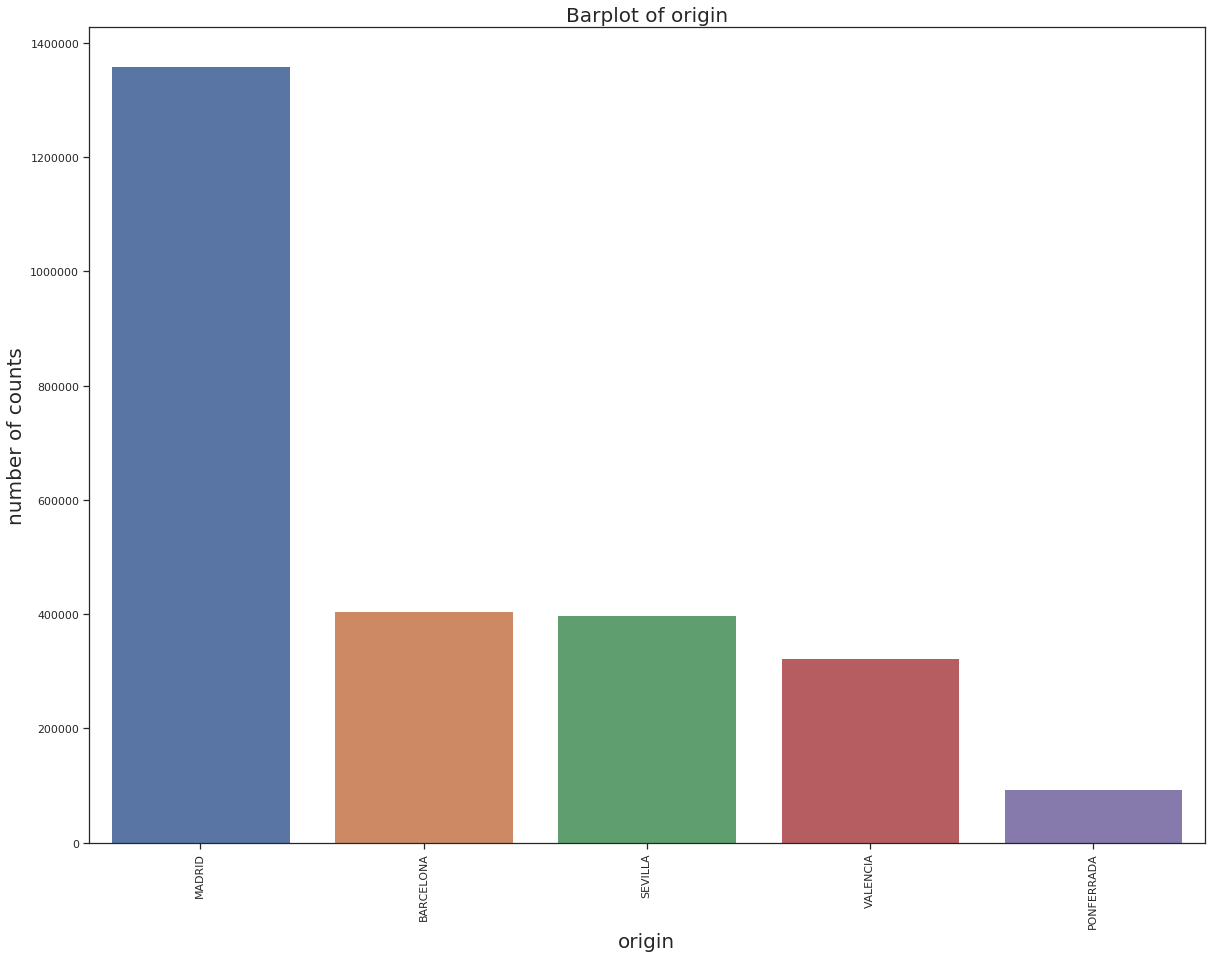

Plotting barplot of destination.... Please be patient!


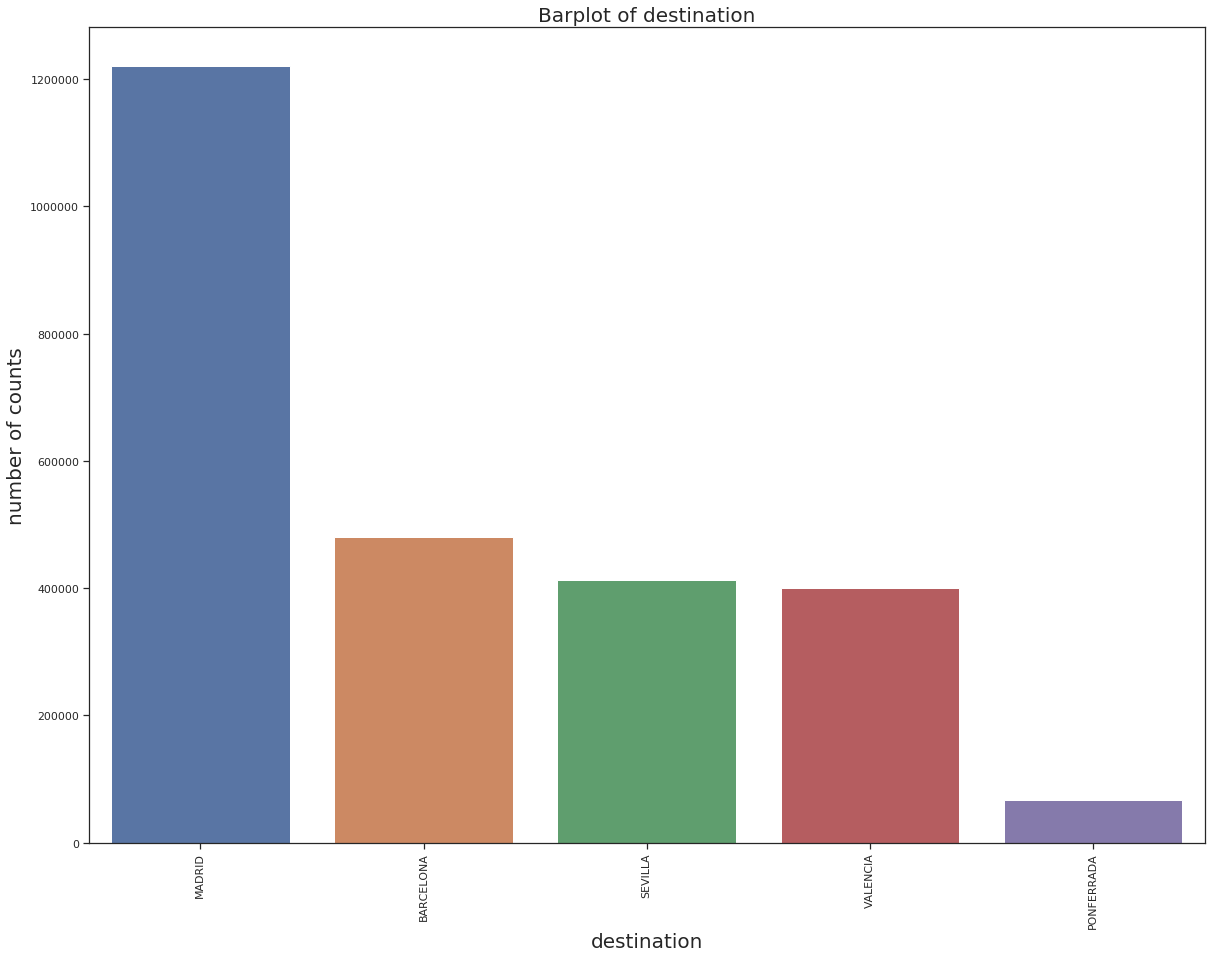

Plotting barplot of train_type.... Please be patient!


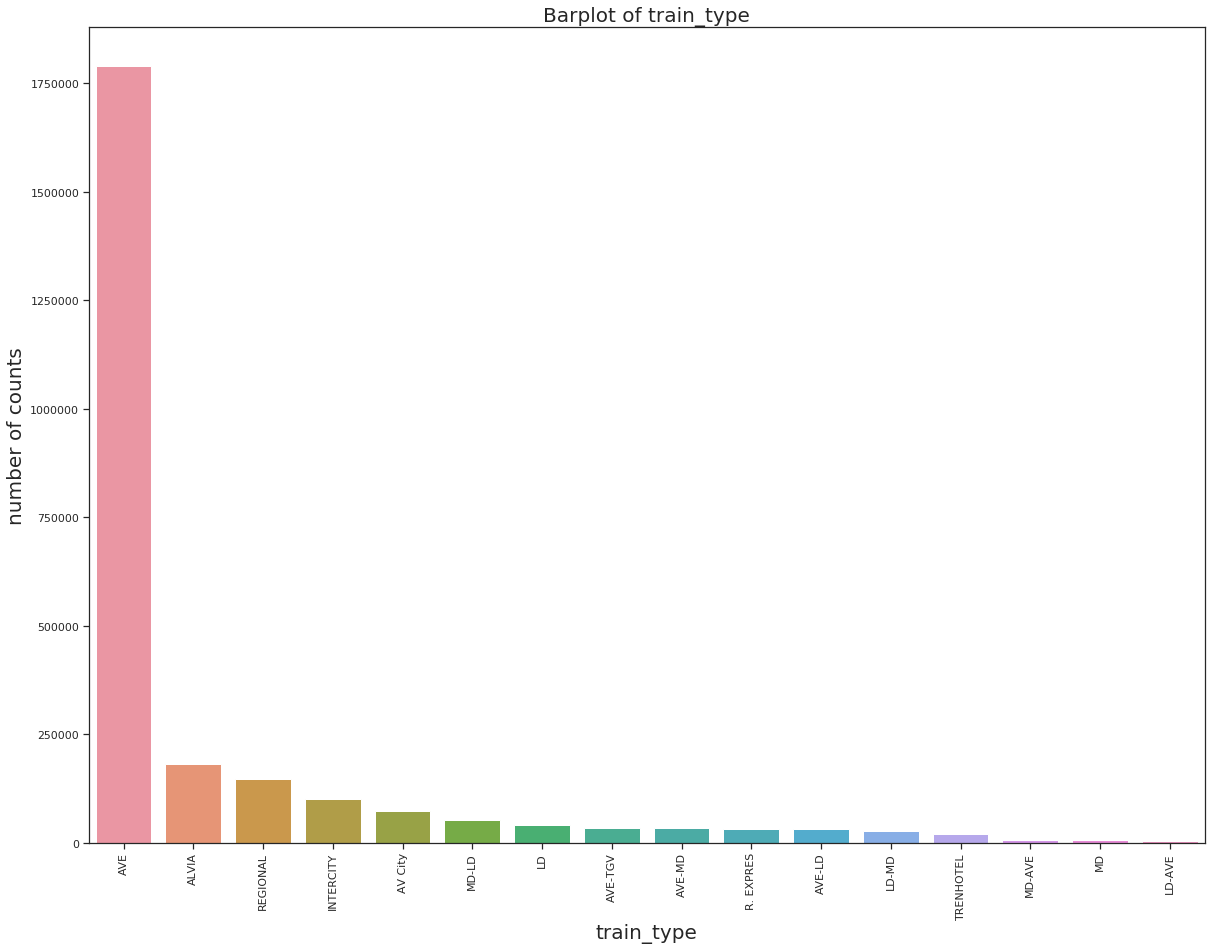

Plotting barplot of train_class.... Please be patient!


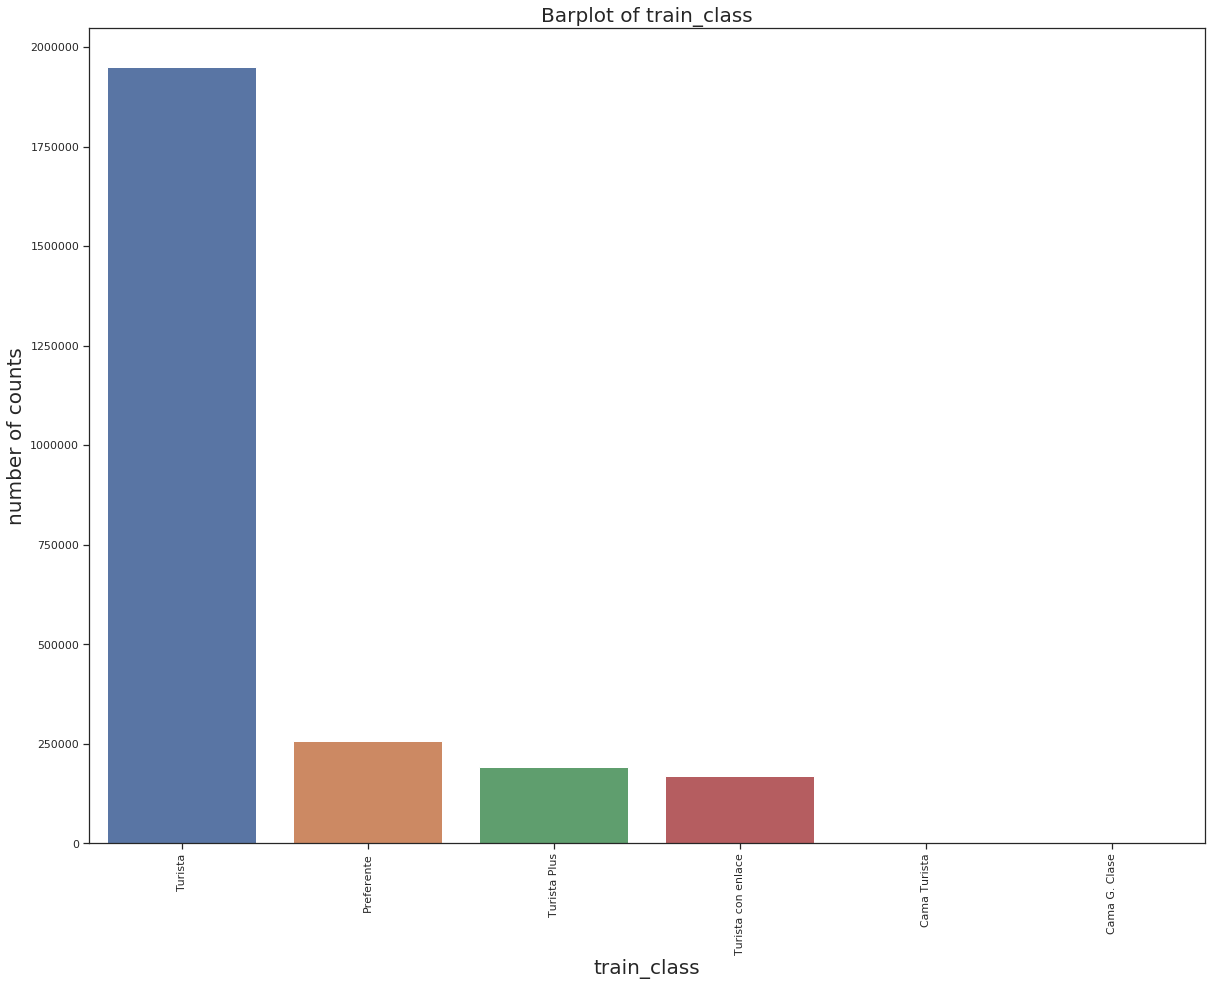

Plotting barplot of fare.... Please be patient!


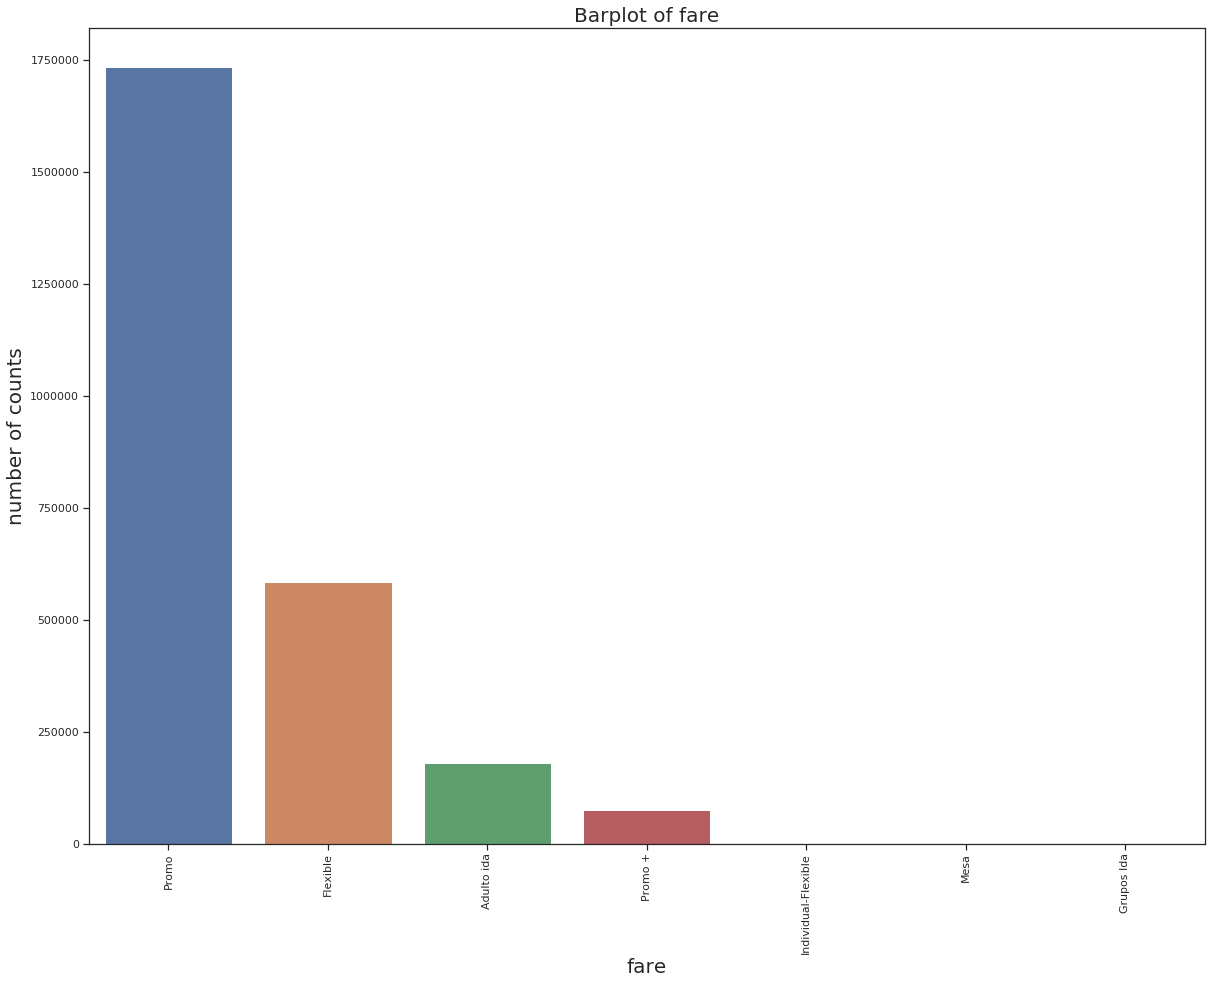

Plotting barplot of insert_date.... Please be patient!


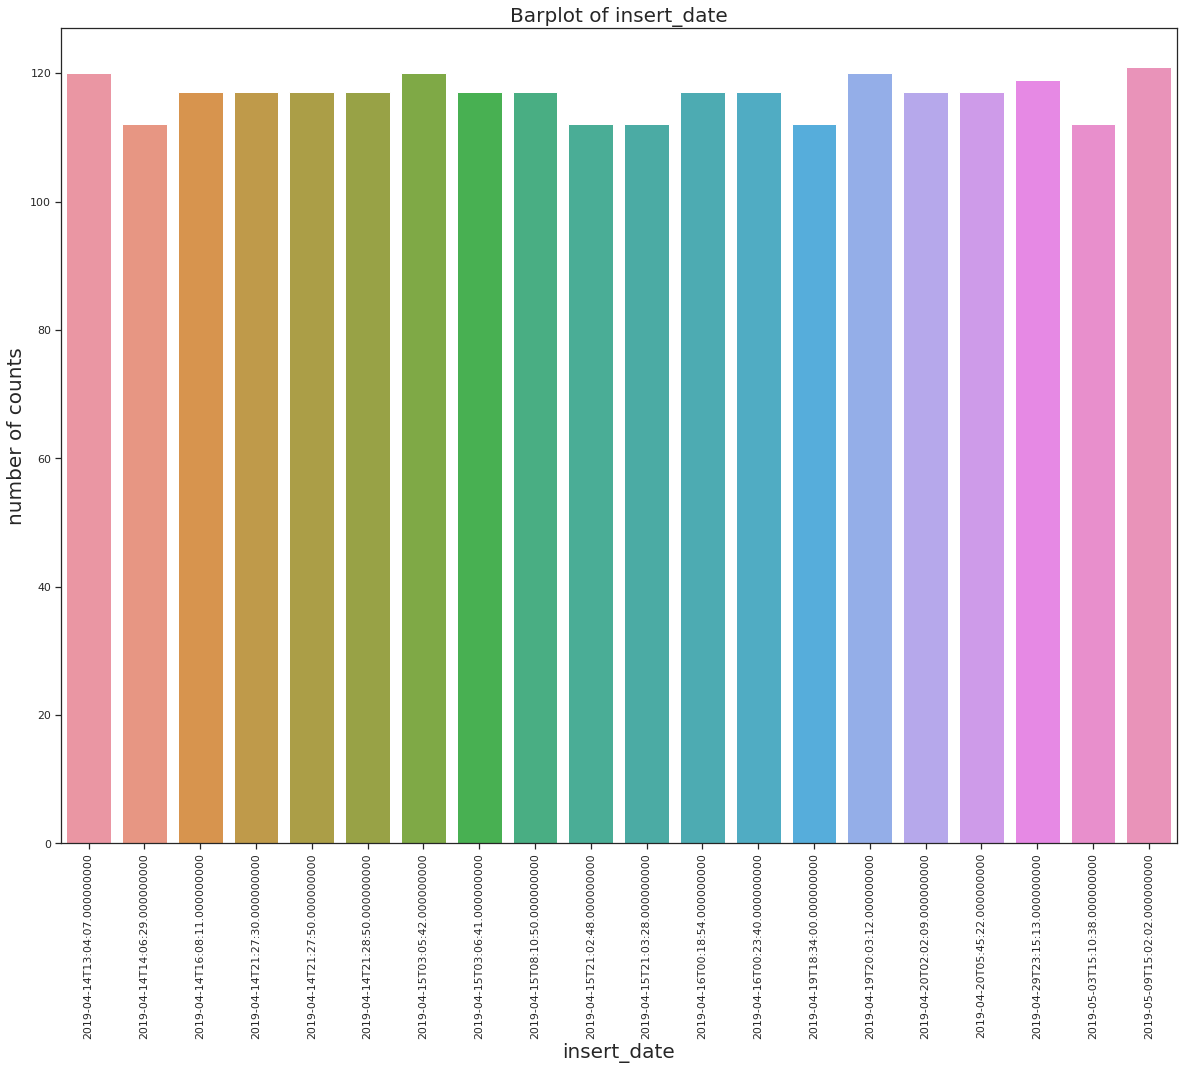

Plotting barplot of start_date.... Please be patient!


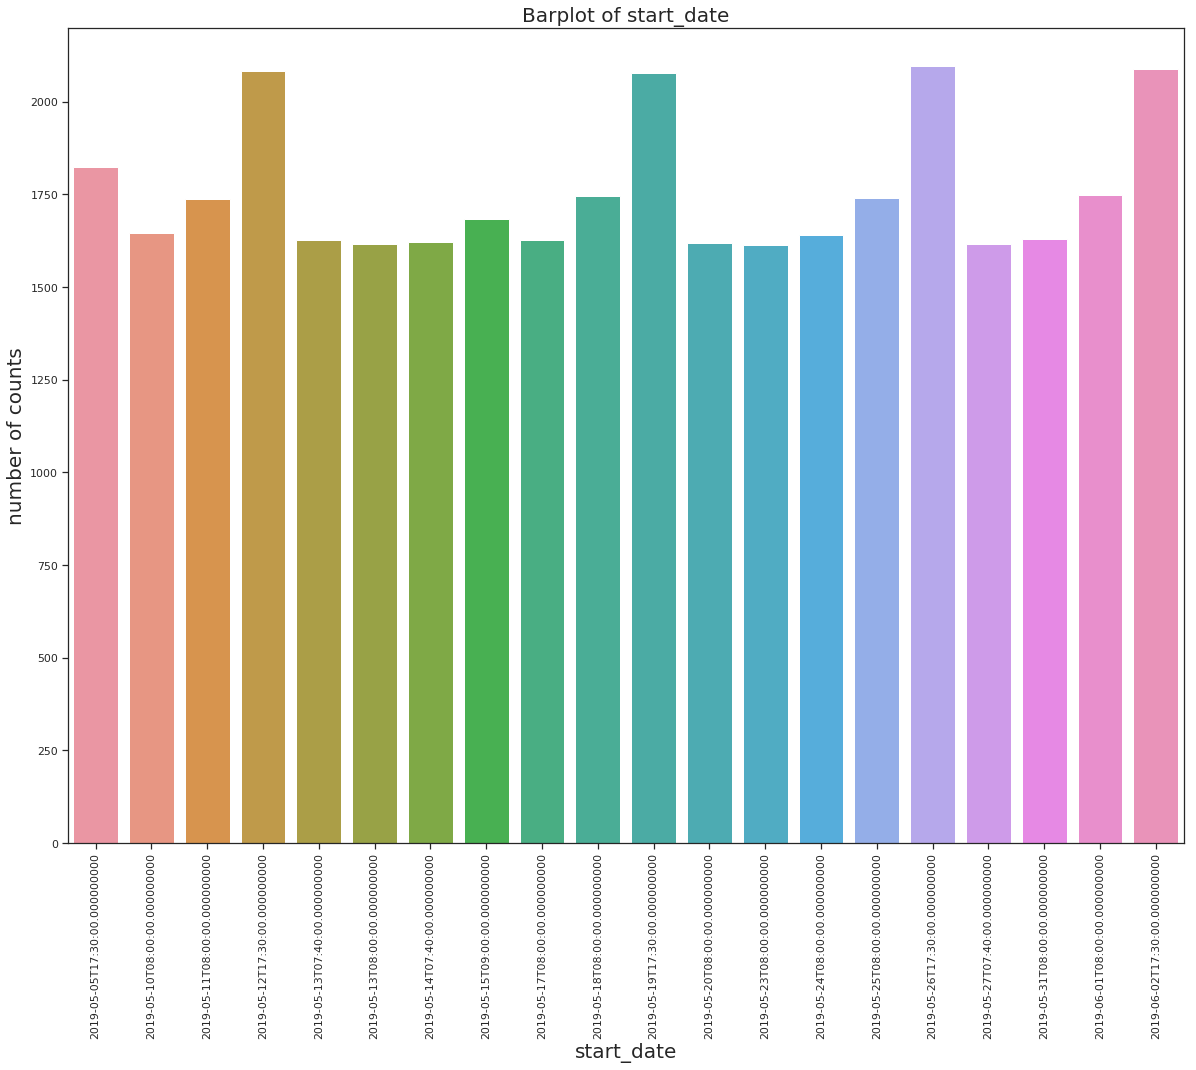

Plotting barplot of end_date.... Please be patient!


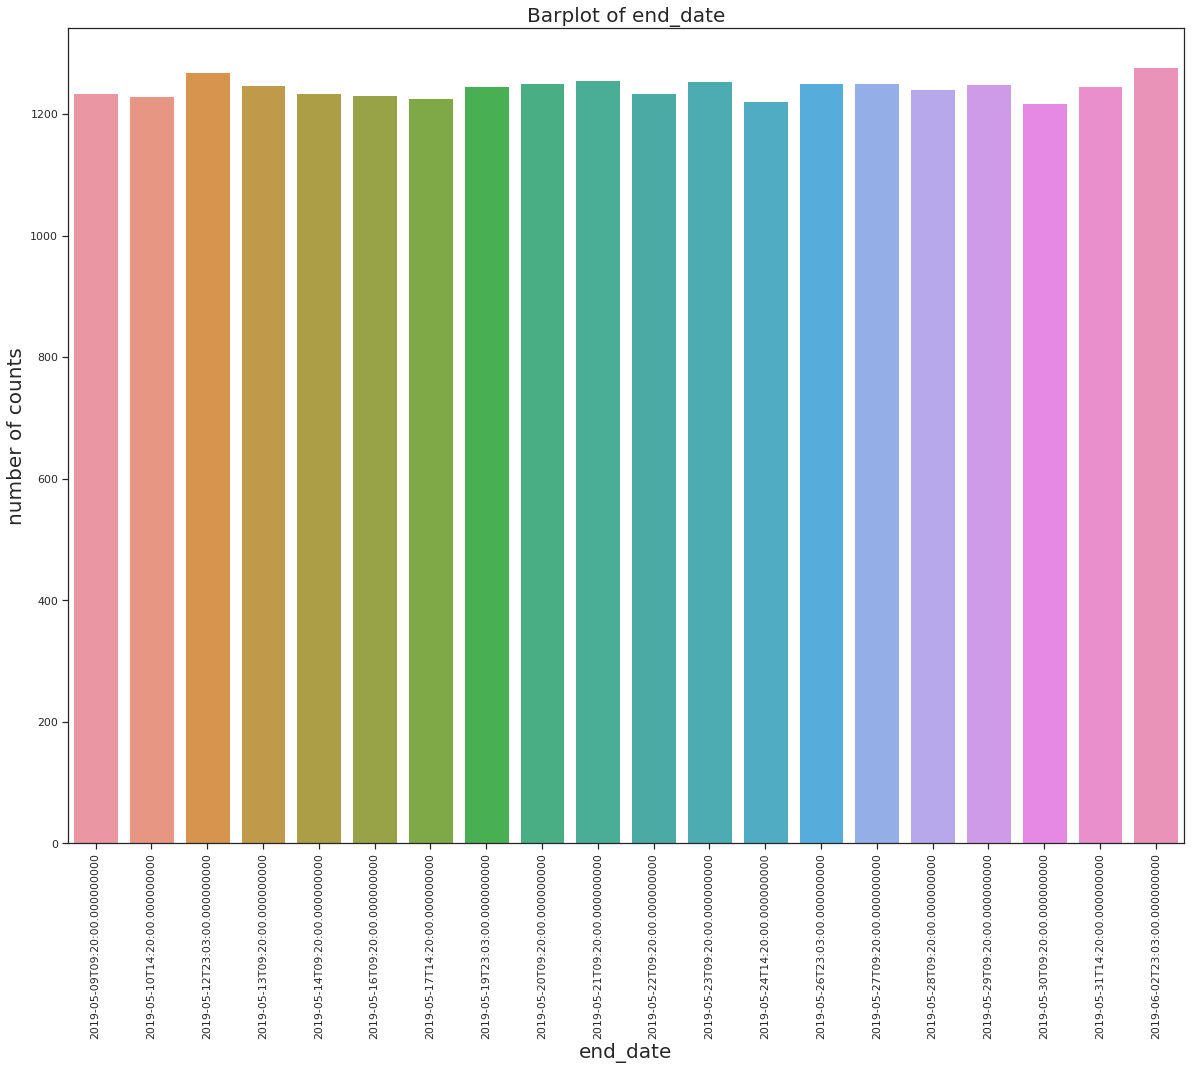

Bar plots are done!
Generate bar plots took = 20.822753429412842 s


In [55]:
bar_plot(data, display=True)

The Histograms plots *.png were located at:
/home/feng/Dropbox/MyTutorial/PythonTipsDS/PythonTipsDS/doc/code/audit/Audited/hist
Plotting histograms of _c0.... Please be patient!


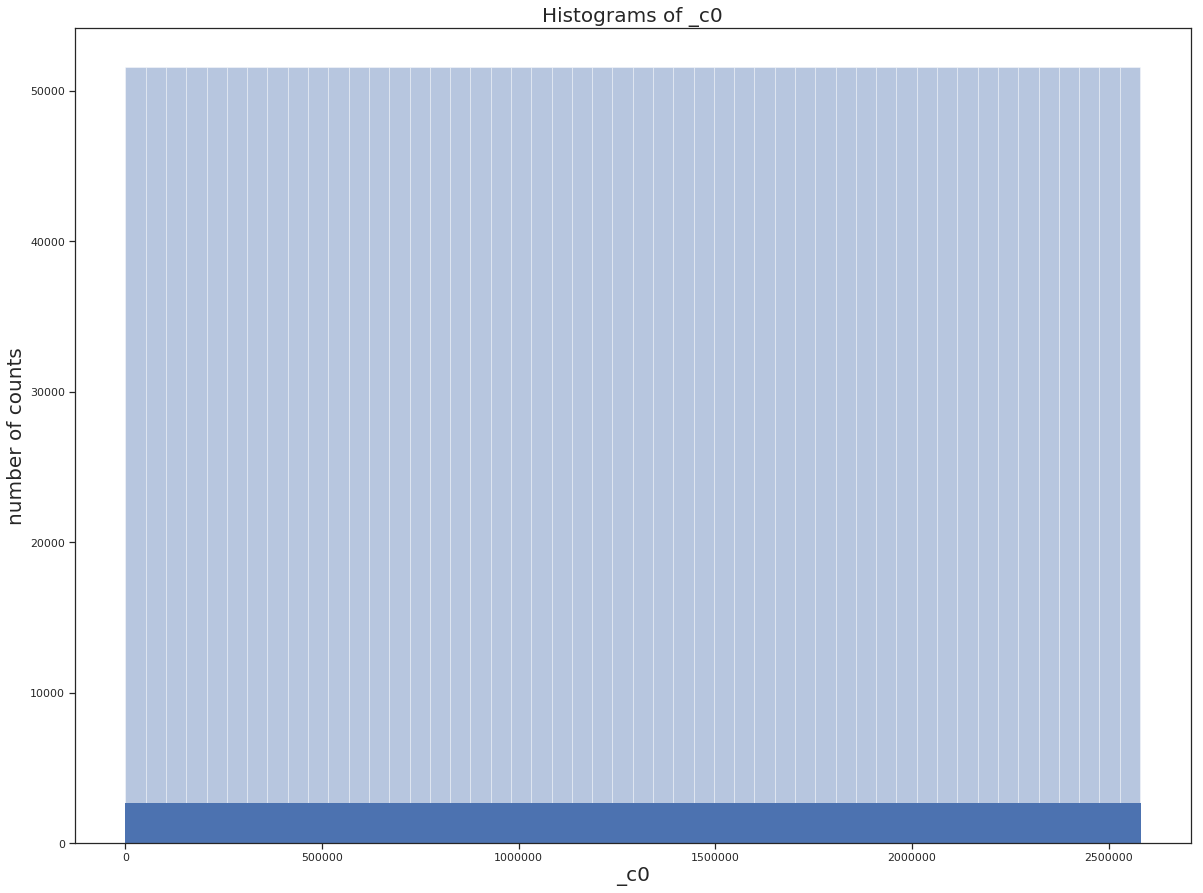

Plotting histograms of price.... Please be patient!


<Figure size 432x288 with 0 Axes>

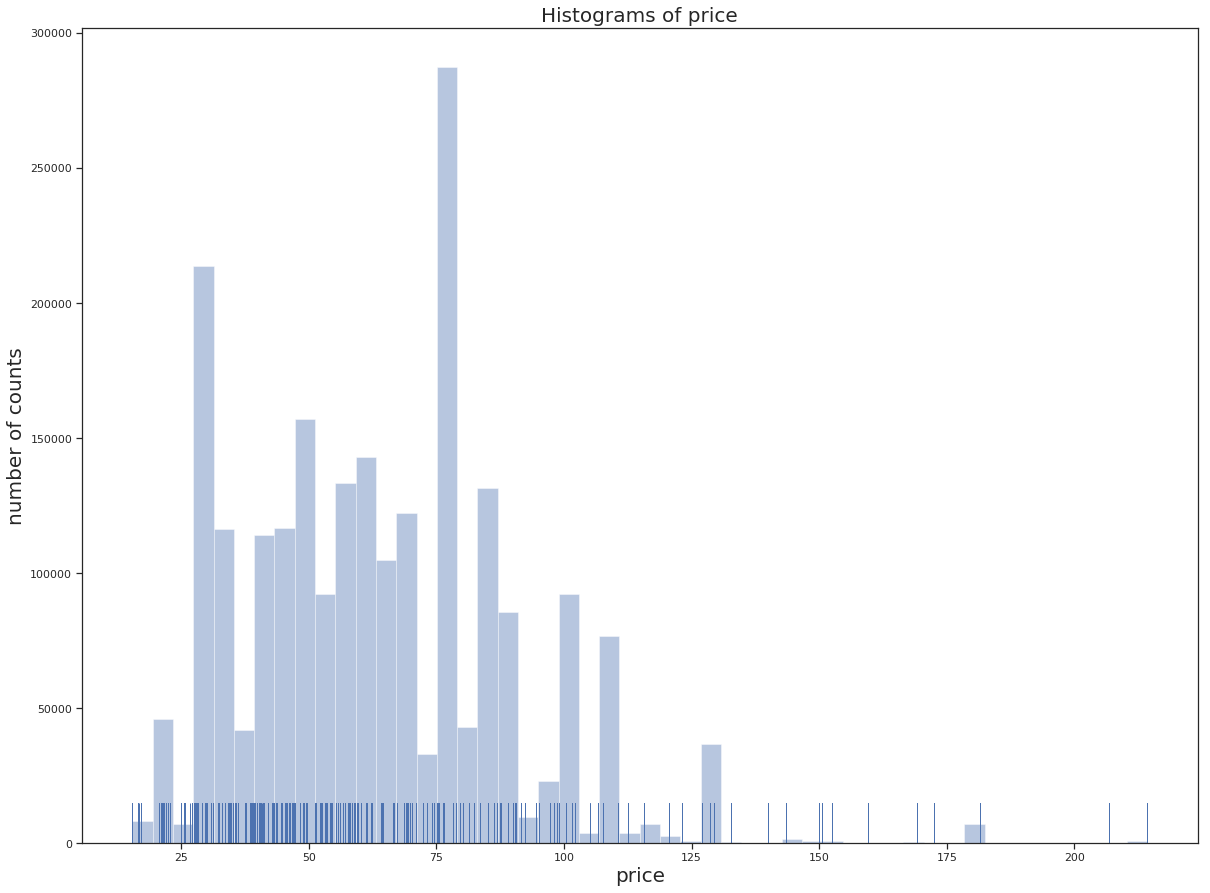

Histograms plots are done!
Generate histograms plots took = 143.25174069404602 s


In [38]:
hist_plot(data, display=True)

In [88]:
def fig_plots(df_in, output_dir=None, bins=50, top_n=20, types='month', d_time=None, rotation=True, sample_size=None, display=False):
    
    start = time.time()  
    hist_plot(df_in,bins=bins,output_dir=output_dir,sample_size=sample_size, display=display)
    bar_plot(df_in, top_n=top_n, rotation=rotation,output_dir=output_dir, display=display)
    trend_plot(df_in, types=types, d_time=d_time, rotation=rotation, output_dir=output_dir, display=display)

    end = time.time()
    print('Generate all the figures took = ' +str(end-start)+' s')  

In [56]:
fig_plots(data)

The Histograms plots *.png were located at:
/home/feng/Dropbox/MyTutorial/PythonTipsDS/PythonTipsDS/doc/code/audit/Audited/hist
Plotting histograms of _c0.... Please be patient!
Plotting histograms of price.... Please be patient!
Histograms plots are done!
Generate histograms plots took = 86.21916246414185 s
The Bar plot Bar_plots.pdf was located at:
/home/feng/Dropbox/MyTutorial/PythonTipsDS/PythonTipsDS/doc/code/audit/Audited
Plotting barplot of origin.... Please be patient!
Plotting barplot of destination.... Please be patient!
Plotting barplot of train_type.... Please be patient!
Plotting barplot of train_class.... Please be patient!
Plotting barplot of fare.... Please be patient!
Plotting barplot of insert_date.... Please be patient!
Plotting barplot of start_date.... Please be patient!
Plotting barplot of end_date.... Please be patient!
Bar plots are done!
Generate bar plots took = 17.475239753723145 s
The Trend plot Trend_plots.pdf was located at:
/home/feng/Dropbox/MyTutorial/P

In [49]:
def dataset_summary(df_in):

    start = time.time()
    sample_size = df_in.count()

    col_names = ['summary', 'value']
    all_fields, num_fields, cat_fields, date_fields, unsupported_fields = dtypes_class(df_in)
    d_types = all_fields.groupby('DataType').count().reset_index()
    d_types.columns = col_names

    cols = df_in.columns
    mask = df_in.withColumn('zero_count', sum(F.when(F.col(c) == '0', 1).otherwise(0) for c in cols)) \
                .withColumn('null_count', sum(F.col(c).isNull().cast('int') for c in cols)) \
                .withColumn('empty_count', sum(F.when(F.trim(F.col(c)) == '', 1).otherwise(0) for c in cols)) \
                .select(['null_count', 'empty_count', 'zero_count'])

    row_w_null = mask.filter(F.col('null_count') > 0).count()
    row_w_empty = mask.filter(F.col('empty_count') > 0).count()
    row_w_zero = mask.filter(F.col('zero_count') > 0).count()

    r_avg = mask.agg(*[F.avg(c).alias('row_avg_' + c) for c in mask.columns]).toPandas().transpose().reset_index()
    r_avg.columns = col_names

    single_unique_feature = sum([df_in.na.drop(subset=[c]).select(c).distinct().count() == 1 for c in cols])


    size_names = ['sample_size', 'feature_size', 'single_unique_feature', 'row_w_null', 'row_w_empty', 'row_w_zero']
    size_values = [sample_size, len(cols), single_unique_feature, row_w_null, row_w_empty, row_w_zero]
    size_summary = pd.DataFrame({'summary': size_names, 'value': size_values})

    avg_summary = r_avg

    field_names = ['numerical_fields', 'categorical_fields', 'date_fields', 'unsupported_fields']
    field_values = [len(num_fields), len(cat_fields), len(date_fields), len(unsupported_fields)]
    field_summary = pd.DataFrame({'summary': field_names, 'value': field_values})

    dtype_summary = pd.DataFrame(df_in.dtypes, columns=['value','dtypes'])\
                      .groupby('dtypes').count().rename_axis('summary').reset_index()


    summary = pd.concat([size_summary, avg_summary, field_summary, dtype_summary], axis=0)
    end = time.time()

    print('Generate data set summary took = ' + str(end - start) + ' s')

    return summary


In [50]:
dataset_summary(data)

Generate data set summary took = 4.80610203742981 s


,summary,value
0,sample_size,303.000000
1,feature_size,14.000000
2,single_unique_feature,0.000000
3,row_w_null,0.000000
4,row_w_empty,0.000000
5,row_w_zero,299.000000
0,row_avg_null_count,0.000000
1,row_avg_empty_count,0.000000
2,row_avg_zero_count,3.250825
0,numerical_fields,10.000000


In [119]:
all_f, num_fields, cat_fields, _, _ = dtypes_class(data)

In [121]:
all_f

,feature,DataType
0,TV,DoubleType
1,Radio,DoubleType
2,Newspaper,DoubleType
3,Sales,DoubleType


In [123]:
def auditing(df_in, writer=None, columns=None, deciles=False, top_freq_item=5 , bins=50, top_cat_item=20, 
             method="pearson", output_dir=None, types='month', d_time=None, rotation=True, sample_size=None, display=False):
    
    if output_dir is None:
        out_path = os.getcwd()+'/Audited'
    else:
        out_path = output_dir+'/Audited'
    mkdir_clean(out_path)
    
    if writer is None:
        writer = pd.ExcelWriter(out_path+'/00-audited_results.xlsx', engine='xlsxwriter')
    else:
        writer = writer

    print('==========================================================')
    print('The audited results summary 00-audited_results.xlsx was located at:')
    print(out_path)
    start = time.time()  
    all_fields, num_fields, cat_fields, _,_ = dtypes_class(df_in)
    
    if all_fields.shape[0]>1:
        set_summary = dataset_summary(df_in)
        set_summary.to_excel(writer, sheet_name='Dataset_summary', index=False) 
    if num_fields:    
        num_summary = numeric_summary(df_in, columns=columns, deciles=deciles, top_n=top_freq_item)
        num_summary.to_excel(writer, sheet_name='Numeric_summary', index=False)
    if cat_fields:
        cat_summary = category_summary(df_in, columns=columns, top_n=top_freq_item)
        cat_summary.to_excel(writer, sheet_name='Category_summary', index=False)
    if len(num_fields)>1:
        corr = corr_matrix(df_in, method=method, output_dir=output_dir, rotation=rotation, display=display)
        corr.to_excel(writer, sheet_name='Correlation_matrix', index=False)    
    
    
    writer.save()
    
    fig_plots(df_in, output_dir=output_dir, bins=bins, top_n=top_cat_item, types=types, d_time=d_time, rotation=rotation, 
              sample_size=sample_size, display=display)
    
    end = time.time()

    print('Generate all audited results took = ' +str(end-start)+' s')
    print('The auditing processes are DONE!!!')   
    
    if display:
        return num_summary, cat_summary, corr

In [132]:
auditing(data, output_dir=path)

The data set summary was located at:
/home/feng/Desktop/Audited
Generate data set summary took = 16.983163595199585 s
Generate counts took = 0.0012826919555664062 s
Generate counts took = 20.399343967437744 s
Generate data frame description took = 2.7250282764434814 s
Calculating percentiles.... Please be patient!
Generate percentiles took = 38.90961194038391 s
Calculating features' length.... Please be patient!
Generate features' length took = 7.447601556777954 s
Calculating top 5 frequent items.... Please be patient!
Generate rates took: 13.595213890075684 s
Calculating rates.... Please be patient!
Generate rates took: 60.40856337547302 s
Auditing numerical data took = 143.52680468559265 s
The correlation matrix plot Corr.png was located at:
/home/feng/Desktop/Audited
Calculating correlation matrix... Please be patient!
Generate correlation matrix took = 12.43299913406372 s
The Histograms plots *.png were located at:
/home/feng/Desktop/Audited/03-hist
Plotting histograms of ambient..